# Métricas de Evaluación de Modelos de Clasificación

Este notebook cubre:
- Métricas de evaluación para modelos de clasificación binaria
- Análisis detallado de las métricas para predicción de fallas
- Visualización de métricas
- Comparación entre Árbol de Decisión y LightGBM

**Modelos evaluados:**
- Árbol de Decisión (Decision Tree)
- LightGBM

## 1. Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import mysql.connector
from mysql.connector import Error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Cargar Datos y Entrenar Modelos

In [2]:
# Configuración de la base de datos
DB_CONFIG = {
    'host': '127.0.0.1',
    'database': 'palantir_maintenance',
    'user': 'root',
    'password': 'admin',
    'port': 3306
}

def cargar_y_preparar_datos():
    """Cargar datos y preparar para evaluación"""
    try:
        connection = mysql.connector.connect(**DB_CONFIG)
        if connection.is_connected():
            query = "SELECT * FROM faliure_probability_base ORDER BY asset_id, reading_date"
            df = pd.read_sql(query, connection)
            connection.close()
            
            # Preparar datos
            exclude_cols = ['base_id', 'asset_id', 'reading_date', 'faliure', 
                           'asset_status', 'created_at', 'updated_at']
            feature_columns = [col for col in df.columns if col not in exclude_cols]
            X = df[feature_columns].select_dtypes(include=[np.number]).fillna(0)
            y = df['faliure'].astype(int)
            
            return X, y
    except Error as e:
        print(f"Error: {e}")
        return None, None

X, y = cargar_y_preparar_datos()

if X is not None and len(np.unique(y)) > 1:
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Escalar
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    # Entrenar Decision Tree
    dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2, 
                                       class_weight='balanced', random_state=42)
    dt_model.fit(X_train_scaled, y_train)
    y_pred_dt = dt_model.predict(X_test_scaled)
    y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
    
    # Entrenar LightGBM
    n_neg = np.sum(y_train == 0)
    n_pos = np.sum(y_train == 1)
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1
    
    lgbm_model = LGBMClassifier(objective='binary', num_leaves=31, learning_rate=0.05,
                                 n_estimators=100, scale_pos_weight=scale_pos_weight,
                                 random_state=42, verbose=-1)
    lgbm_model.fit(X_train_scaled_df, y_train)
    y_pred_lgbm = lgbm_model.predict(X_test_scaled_df)
    y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"Datos cargados: {X.shape}")
    print(f"Modelos entrenados correctamente")
else:
    print("Error al cargar datos o solo hay una clase")

Datos cargados: (1200, 36)
Modelos entrenados correctamente


## 3. Métricas Básicas de Clasificación

### 3.1 Explicación de las Métricas

- **Accuracy:** Proporción de predicciones correctas sobre el total. (TP + TN) / (TP + TN + FP + FN)
- **Precision:** Proporción de predicciones positivas que son correctas. TP / (TP + FP)
- **Recall:** Proporción de casos positivos correctamente identificados. TP / (TP + FN)
- **F1-Score:** Media armónica de Precision y Recall. 2 * (Precision * Recall) / (Precision + Recall)

In [3]:
def calcular_metricas(y_true, y_pred, y_pred_proba, nombre_modelo):
    """Calcular y mostrar métricas de clasificación"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    metricas = {
        'Modelo': nombre_modelo,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    if len(np.unique(y_true)) > 1:
        metricas['AUC-ROC'] = roc_auc_score(y_true, y_pred_proba)
        metricas['Avg Precision'] = average_precision_score(y_true, y_pred_proba)
    
    print(f"\n{'='*50}")
    print(f"Métricas para {nombre_modelo}")
    print(f"{'='*50}")
    print(f"Accuracy:      {accuracy:.4f}")
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"F1-Score:      {f1:.4f}")
    if 'AUC-ROC' in metricas:
        print(f"AUC-ROC:       {metricas['AUC-ROC']:.4f}")
        print(f"Avg Precision: {metricas['Avg Precision']:.4f}")
    
    return metricas

if 'y_test' in locals():
    metricas_dt = calcular_metricas(y_test, y_pred_dt, y_pred_proba_dt, "Árbol de Decisión")
    metricas_lgbm = calcular_metricas(y_test, y_pred_lgbm, y_pred_proba_lgbm, "LightGBM")


Métricas para Árbol de Decisión
Accuracy:      0.9833
Precision:     0.8636
Recall:        0.9500
F1-Score:      0.9048
AUC-ROC:       0.9706
Avg Precision: 0.8694

Métricas para LightGBM
Accuracy:      0.9917
Precision:     0.9500
Recall:        0.9500
F1-Score:      0.9500
AUC-ROC:       0.9986
Avg Precision: 0.9885


## 4. Matriz de Confusión Detallada

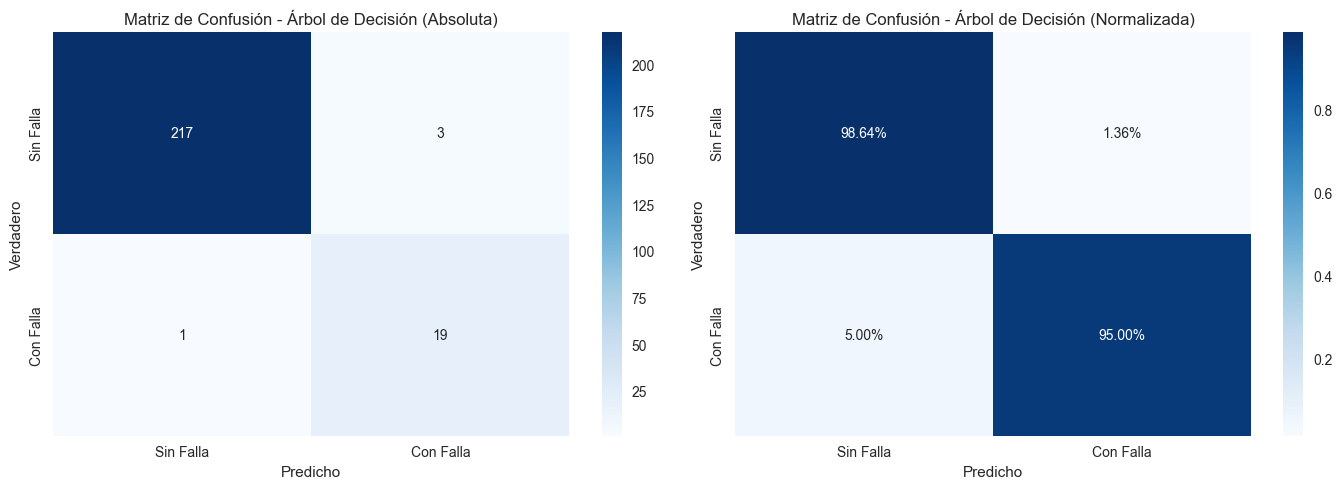


Desglose para Árbol de Decisión:
  Verdaderos Negativos (TN): 217
  Falsos Positivos (FP):     3
  Falsos Negativos (FN):     1
  Verdaderos Positivos (TP): 19


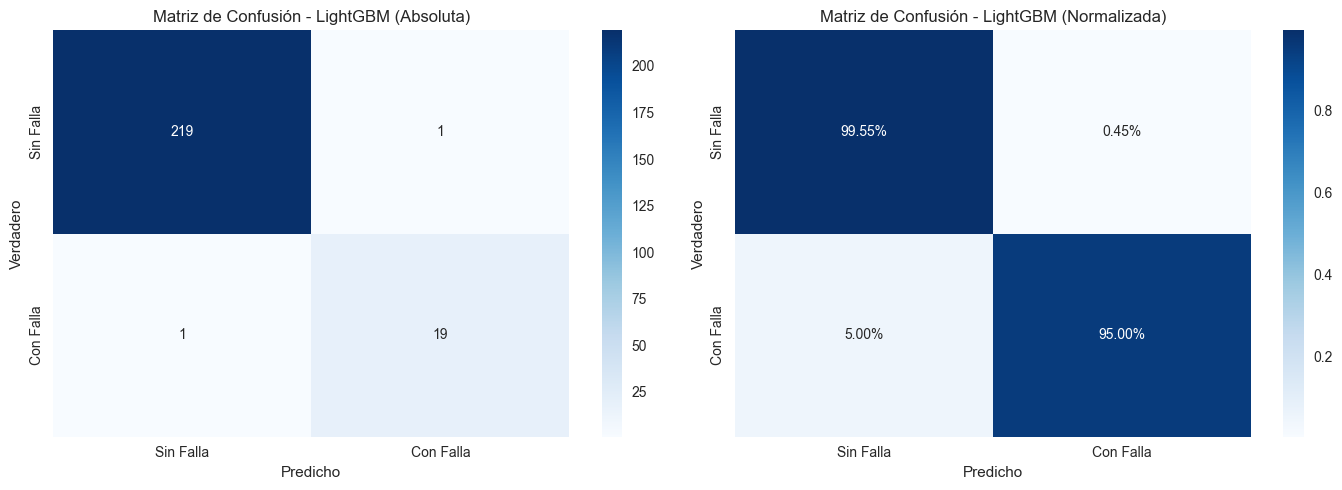


Desglose para LightGBM:
  Verdaderos Negativos (TN): 219
  Falsos Positivos (FP):     1
  Falsos Negativos (FN):     1
  Verdaderos Positivos (TP): 19


In [4]:
def plot_confusion_matrix_detallada(y_true, y_pred, nombre_modelo):
    """Visualizar matriz de confusión con métricas adicionales"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matriz absoluta
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Sin Falla', 'Con Falla'],
                yticklabels=['Sin Falla', 'Con Falla'])
    axes[0].set_title(f'Matriz de Confusión - {nombre_modelo} (Absoluta)')
    axes[0].set_ylabel('Verdadero')
    axes[0].set_xlabel('Predicho')
    
    # Matriz normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
                xticklabels=['Sin Falla', 'Con Falla'],
                yticklabels=['Sin Falla', 'Con Falla'])
    axes[1].set_title(f'Matriz de Confusión - {nombre_modelo} (Normalizada)')
    axes[1].set_ylabel('Verdadero')
    axes[1].set_xlabel('Predicho')
    
    plt.tight_layout()
    plt.show()
    
    # Calcular métricas detalladas
    tn, fp, fn, tp = cm.ravel()
    print(f"\nDesglose para {nombre_modelo}:")
    print(f"  Verdaderos Negativos (TN): {tn}")
    print(f"  Falsos Positivos (FP):     {fp}")
    print(f"  Falsos Negativos (FN):     {fn}")
    print(f"  Verdaderos Positivos (TP): {tp}")

if 'y_test' in locals():
    plot_confusion_matrix_detallada(y_test, y_pred_dt, "Árbol de Decisión")
    plot_confusion_matrix_detallada(y_test, y_pred_lgbm, "LightGBM")

## 5. Classification Report Detallado

In [5]:
if 'y_test' in locals():
    print("="*60)
    print("Classification Report - Árbol de Decisión")
    print("="*60)
    print(classification_report(y_test, y_pred_dt, 
                                target_names=['Sin Falla', 'Con Falla'],
                                zero_division=0))
    
    print("\n" + "="*60)
    print("Classification Report - LightGBM")
    print("="*60)
    print(classification_report(y_test, y_pred_lgbm, 
                                target_names=['Sin Falla', 'Con Falla'],
                                zero_division=0))

Classification Report - Árbol de Decisión
              precision    recall  f1-score   support

   Sin Falla       1.00      0.99      0.99       220
   Con Falla       0.86      0.95      0.90        20

    accuracy                           0.98       240
   macro avg       0.93      0.97      0.95       240
weighted avg       0.98      0.98      0.98       240


Classification Report - LightGBM
              precision    recall  f1-score   support

   Sin Falla       1.00      1.00      1.00       220
   Con Falla       0.95      0.95      0.95        20

    accuracy                           0.99       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.99      0.99      0.99       240



## 6. Curvas ROC

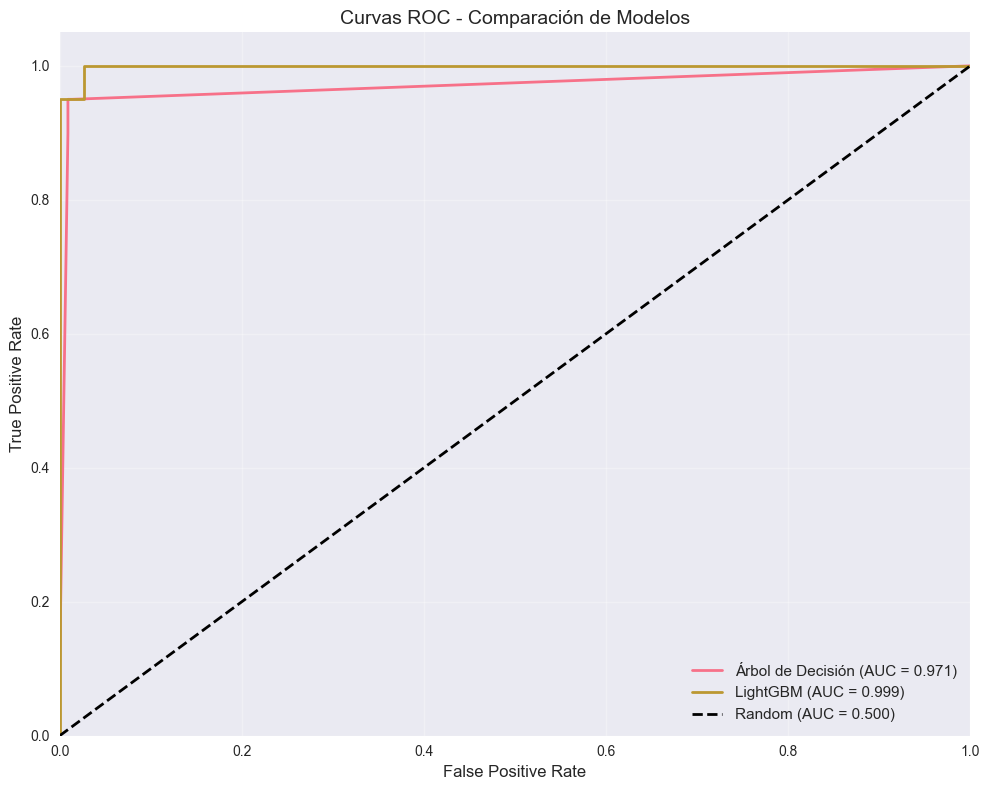

In [6]:
if 'y_test' in locals() and len(np.unique(y_test)) > 1:
    plt.figure(figsize=(10, 8))
    
    # Árbol de Decisión
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
    auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
    plt.plot(fpr_dt, tpr_dt, lw=2, label=f'Árbol de Decisión (AUC = {auc_dt:.3f})')
    
    # LightGBM
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
    auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
    plt.plot(fpr_lgbm, tpr_lgbm, lw=2, label=f'LightGBM (AUC = {auc_lgbm:.3f})')
    
    # Línea diagonal (random)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Curvas ROC - Comparación de Modelos', fontsize=14)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes clases para calcular curvas ROC")

## 7. Curvas Precision-Recall

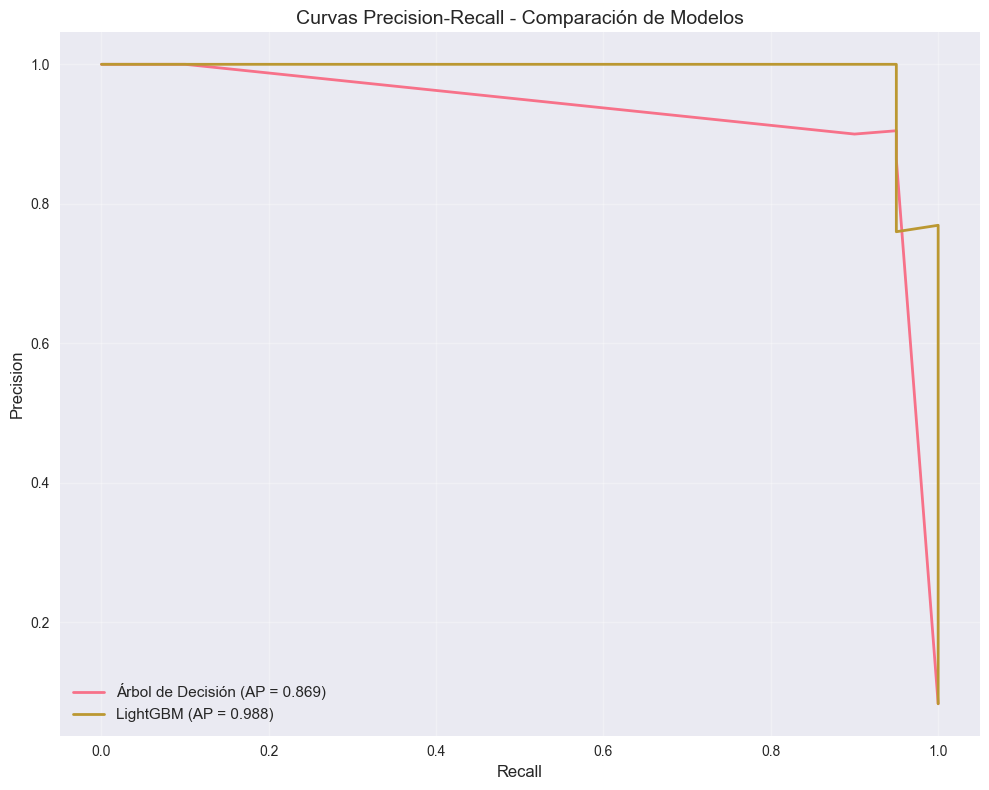

In [7]:
if 'y_test' in locals() and len(np.unique(y_test)) > 1:
    plt.figure(figsize=(10, 8))
    
    # Árbol de Decisión
    precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
    ap_dt = average_precision_score(y_test, y_pred_proba_dt)
    plt.plot(recall_dt, precision_dt, lw=2, label=f'Árbol de Decisión (AP = {ap_dt:.3f})')
    
    # LightGBM
    precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
    ap_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)
    plt.plot(recall_lgbm, precision_lgbm, lw=2, label=f'LightGBM (AP = {ap_lgbm:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Curvas Precision-Recall - Comparación de Modelos', fontsize=14)
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes clases para calcular curvas PR")

## 8. Comparación Completa de Métricas


COMPARACIÓN COMPLETA DE MODELOS
           Modelo  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Avg Precision
Árbol de Decisión    0.9833     0.8636    0.95    0.9048   0.9706         0.8694
         LightGBM    0.9917     0.9500    0.95    0.9500   0.9986         0.9885


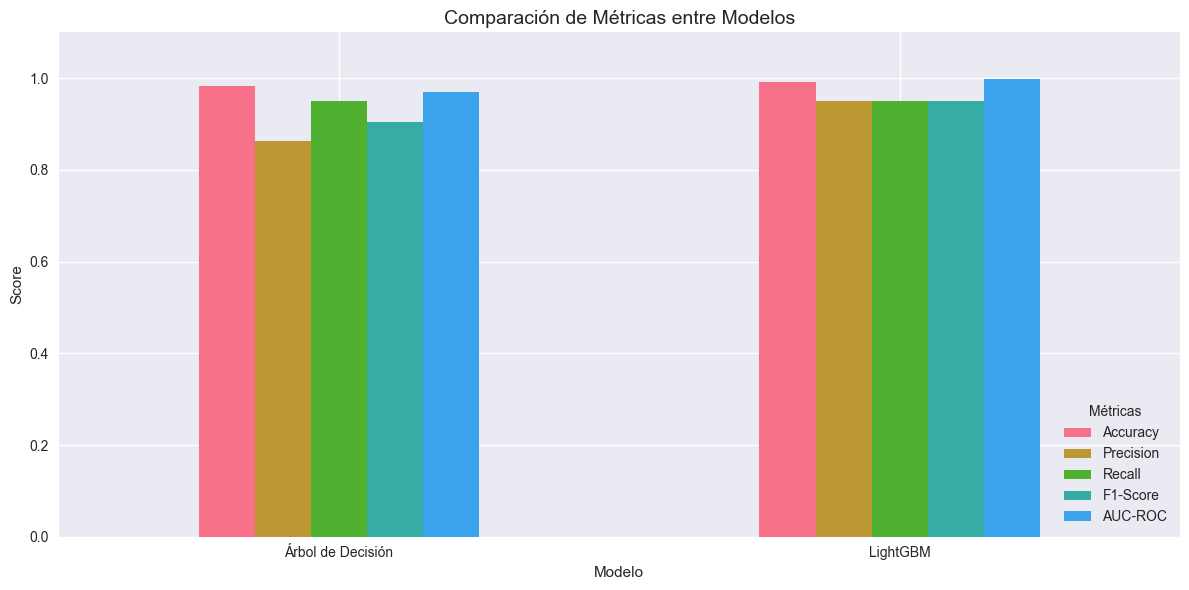


✓ Mejor modelo (basado en F1-Score): LightGBM


In [8]:
if 'metricas_dt' in locals() and 'metricas_lgbm' in locals():
    df_comparacion = pd.DataFrame([metricas_dt, metricas_lgbm])
    
    print("\n" + "="*70)
    print("COMPARACIÓN COMPLETA DE MODELOS")
    print("="*70)
    print(df_comparacion.round(4).to_string(index=False))
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    if 'AUC-ROC' in df_comparacion.columns:
        metrics_to_plot.append('AUC-ROC')
    
    df_comparacion.set_index('Modelo')[metrics_to_plot].plot(kind='bar', ax=ax)
    plt.title('Comparación de Métricas entre Modelos', fontsize=14)
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(title='Métricas', loc='lower right')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()
    
    # Mejor modelo
    best_model = df_comparacion.loc[df_comparacion['F1-Score'].idxmax(), 'Modelo']
    print(f"\n✓ Mejor modelo (basado en F1-Score): {best_model}")

## Resumen

En este notebook hemos aprendido:
1. ✅ Métricas básicas de clasificación (Accuracy, Precision, Recall, F1-Score)
2. ✅ Análisis detallado de matrices de confusión
3. ✅ Classification reports por clase
4. ✅ Curvas ROC para clasificación binaria
5. ✅ Curvas Precision-Recall
6. ✅ Comparación entre Árbol de Decisión y LightGBM